average sum : 109.335
average old : 18.55


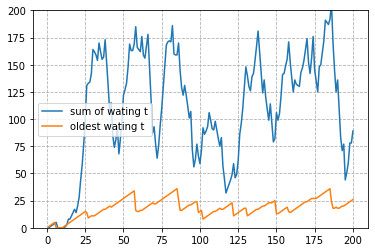

In [13]:
from collections import deque
from random import randint, uniform
from copy import deepcopy
from math import sin, ceil
import numpy as np
import matplotlib.pyplot as plt

def pop_front(road, idx, cond, outlane):
    if len(road[idx]) > 0 and road[idx][0][1] == cond:
        road[idx].popleft()
        outlane[idx] = 1

def sine_prob(time):
    seed = sin(time / 4) + sin(time / 2) + 1.5
    # return uniform(0, seed + 1.5)
    return seed + uniform(0, 3)

# print(list(sine_prob(t) for t in range(20)))
# exit()

class Junction:
    def __init__(self, lim=10):
        # 3차선 도로 4개
        # i 번째 도로 j 차선 = i * 3 + j
        # 0번과 1번 도로는 마주보고 있고 2번과 3번 도로는 마주보고 있다.
        # 0차선: 좌회전 1차선: 직진 2차선:우회전/직진
        self.road = list(deque() for i in range(12))
        self.time = 0
        self.lim = lim
        self.info = []
        self.signal = -1

        self.test = [0, 0, 0, 0]

    def cars_in(self, skip):
        road = self.road
        for i in range(12):
            if i in skip:
                continue
            # 12 차선에 대해 차량이 들어온다.
            if sine_prob(self.time) < 1.6:
                # 일정한 분포에 의해 들어오는 차량의 수가 정해진다.
                road[i].append([self.time, i % 3])
                self.test[i // 3] += 1
                # if i % 3 == 2:
                #     # 우회전 차선의 경우에는 직진 혹은 우회전
                #     road[i].append([self.time, randint(1, 2)])
                # else:
                #     # 좌회전이나 직진 차선의 경우에는 차선에 맞는 방향
                #     road[i].append([self.time, i % 3])

    def cars_out(self, action):
        road = self.road
        outlane = list(0 for i in range(12))

        if action < 2:
            # 마주보는 차선 좌회전
            pop_front(road, action * 6, 0, outlane)
            pop_front(road, action * 6 + 3, 0, outlane)
        elif action < 4:
            # 마주보는 차선 직진
            action -= 2
            pop_front(road, action * 6 + 1, 1, outlane)
            pop_front(road, action * 6 + 4, 1, outlane)
        else:
            # 한 차선 직진 and 좌회전
            action -= 4
            pop_front(road, action * 3, 0, outlane)
            pop_front(road, action * 3 + 1, 1, outlane)
            pop_front(road, action * 3 + 2, 1, outlane)
                
        for i in range(4):
            # 모든 도로 우회전
            pop_front(road, i * 3 + 2, 2, outlane)

        return outlane
    
    def step(self, action):
        if action > 7 or action < 0:
            # 잘못된 입력이 들어 올 경우
            return -1
        # 차가 들어오는 경우
        prev = sum(sum((self.time - car[0]) ** 1 for car in road) for road in self.road)
        self.cars_in([])
        if self.signal == action:
            # 차가 신호에 의해 나가는 경우
            self.cars_out(action)
        self.signal = action

        s = self.get_state()
        r, d = self.get_reward(prev)
        self.time += 1
        if d == 0:
            self.info.append([self.time, prev, self.get_oldest()])

        return s, r, d

    def get_oldest(self):
        old = 0
        for i in range(12):
            if len(self.road[i]):
                old = max(old, max(self.time - car[0] for car in self.road[i]))

        return old

    def get_reward(self, prev):
        if any(len(road) >= self.lim for road in self.road):
            return -1000, 1
        waiting = sum(sum((self.time - car[0]) ** 1 for car in road) for road in self.road)
        reward = prev - waiting
        return reward, 0
        
    def get_state(self):
        # s = np.zeros((12, 10))
        # for i in range(12):
        #     for idx, j in enumerate(self.road[i]):
        #         if idx == 10:
        #             break
        #         s[i, idx] = self.time - j[0]

        s = np.zeros((12, 3))
        # 0: oldest 1: avg 2: count 
        for i in range(12):
            s[i][0] = max(self.time - car[0] for car in self.road[i]) if len(self.road[i]) else 0
            s[i][1] = sum(self.time - car[0] for car in self.road[i]) / len(self.road[i]) if len(self.road[i]) else 0
            s[i][2] = len(self.road[i])

        return s

    def render(self):
        d = ["L", "S", "R"]
        string = ""
        for i in range(4):
            string += f"road {i}\n"
            for j in range(3):
                string += d[j] + " " + ' '.join(str(self.time - car[0]) for car in self.road[i * 3 + j]) + "\n"
                # print(d[j], ' '.join(str(self.time - car[0]) for car in self.road[i * 3 + j]))
        string += "Selected signal: " + str(self.signal) + "\n"
        # print("Selected signal:", self.signal)

        return string

    def save_graph(self, name):
        info = np.array(self.info)
        t, w, o = info[:, 0], info[:, 1], info[:, 2]
        plt.plot(t, w, label="sum of wating t")
        plt.plot(t, o, label="oldest wating t")
        plt.ylim(0, 200)
        plt.grid(linestyle='--')
        plt.legend()
        print("average sum :", sum(w)/t[-1])
        print("average old :", sum(o)/t[-1])
        plt.savefig(name)
        plt.show()

def MC(env):
    li = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            for k in range(5):
                tmp = deepcopy(env)
                s1, r1, d1 = tmp.step(i)
                s2, r2, d2 = tmp.step(j)
                li[i, j] += r1 + r2
            li[i, j] /= 5

    return np.argmax(li) // 8

if __name__ == "__main__":
    from time import sleep
    env = Junction()

    for ep in range(200):
#         a = MC(env)
        # MC Agent
        # a = randint(0, 7)
        # Random Agent
        seq = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7]
        a = seq[ep % 32]
        # Sequential Agent

        s, r, d = env.step(a)

        # render
#         print(env.render())
#         print("sum of waiting time", abs(r))
#         sleep(0.1)

        # print("longest waiting time", old)
        if d == 1:
            break
        # sleep(3)

    env.save_graph("fig1.png")
